# machine_learning.ipynb

## 1. Introducción

En este Notebook, vamos a:
1. Cargar los distintos datasets de entrenamiento y test (con/sin outliers, normalizados o escalados).
2. Entrenar un modelo de **Regresión Logística** en cada uno de ellos y medir su desempeño.
3. Escoger el mejor dataset con base en las métricas.
4. Realizar una **búsqueda de hiperparámetros** (*GridSearchCV*) para optimizar el modelo ganador.
5. Guardar o mostrar los resultados finales.

Este enfoque modular permite:
- Comparar rápidamente múltiples versiones de preprocesamiento (outliers, escalados, etc.).
- Reutilizar el mismo pipeline en proyectos futuros con datasets distintos.


In [52]:

# 1. Importación de librerías

import os
import pandas as pd
import numpy as np

# Para modelado
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Ignorar warnings (opcional)
import warnings
warnings.filterwarnings("ignore")



## 2. Carga de datos

En este apartado, definimos las rutas de los archivos `.xlsx` que contienen los distintos **X_train** y **X_test** (con outliers, sin outliers, normalizados, escalados, etc.), así como los vectores `y_train` y `y_test`. 


In [53]:

# 2. Carga de datos

# Ruta base a la carpeta processed
BASE_PATH = "/workspaces/ejercicio_regresion_logistica/data/processed"

# Archivos disponibles según tu carpeta
TRAIN_PATHS = [
    "X_train_con_outliers.xlsx",
    "X_train_sin_outliers.xlsx",
    "X_train_con_outliers_norm.xlsx",
    "X_train_sin_outliers_norm.xlsx",
    "X_train_con_outliers_scal.xlsx",
    "X_train_sin_outliers_scal.xlsx"
]
TRAIN_DATASETS = []
for path in TRAIN_PATHS:
    TRAIN_DATASETS.append(
        # pd.read_excel(BASE_PATH + "/" + path)
        pd.read_excel(f"{BASE_PATH}/{path}")
        # pd.read_excel(os.path.join(BASE_PATH, path))
    )

TEST_PATHS = [
    "X_test_con_outliers.xlsx",
    "X_test_sin_outliers.xlsx",
    "X_test_con_outliers_norm.xlsx",
    "X_test_sin_outliers_norm.xlsx",
    "X_test_con_outliers_scal.xlsx",
    "X_test_sin_outliers_scal.xlsx"
]
TEST_DATASETS = []
for path in TEST_PATHS:
    TEST_DATASETS.append(
        pd.read_excel(f"{BASE_PATH}/{path}")
    )

y_train = pd.read_excel(f"{BASE_PATH}/y_train.xlsx")
y_test = pd.read_excel(f"{BASE_PATH}/y_test.xlsx")

# Verificación
print("Cantidad de datasets de TRAIN cargados:", len(TRAIN_DATASETS))
print("Cantidad de datasets de TEST cargados:", len(TEST_DATASETS))


Cantidad de datasets de TRAIN cargados: 6
Cantidad de datasets de TEST cargados: 6


In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

results = []
for index, dataset in enumerate(TRAIN_DATASETS):
    print(index)
    model = LogisticRegression(random_state = 42)
    model.fit(dataset, y_train)
    y_pred_train = model.predict(dataset)
    y_pred_test = model.predict(TEST_DATASETS[index])

    results.append(
        {
            "train": accuracy_score(y_train, y_pred_train),
            "test": accuracy_score(y_test, y_pred_test)
        }
    )

results


0
1
2
3
4
5


[{'train': 0.9097449908925319, 'test': 0.9034725594949005},
 {'train': 0.9036733454766241, 'test': 0.8970373967945605},
 {'train': 0.9110200364298725, 'test': 0.9038368139873725},
 {'train': 0.9048876745598057, 'test': 0.8992229237493929},
 {'train': 0.9112325440194292, 'test': 0.9023797960174842},
 {'train': 0.9048876745598057, 'test': 0.8992229237493929}]

In [55]:

# 4. Optimización con GridSearchCV del mejor modelo

# Suponiendo que el dataset seleccionado fue el tercero (por ejemplo, con variables seleccionadas)
best_dataset = 2  # Esto lo puedes ajustar según los resultados del paso anterior

# Definimos los hiperparámetros para buscar
hyperparams = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "penalty": ["l1", "l2", "elasticnet", None],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
}

from sklearn.model_selection import GridSearchCV

model = LogisticRegression(random_state = 42)
grid = GridSearchCV(model, hyperparams, scoring = "accuracy")
grid


GridSearchCV(estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

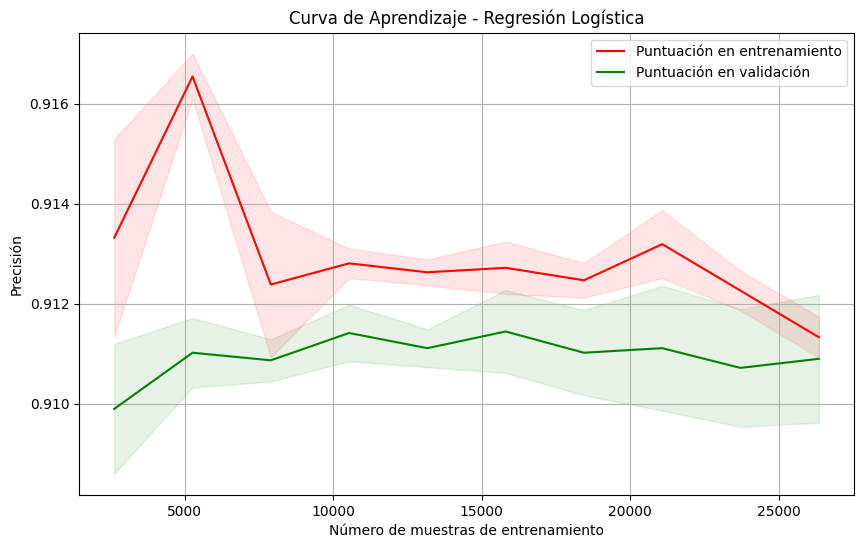

In [60]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Seleccionamos el dataset que usaremos para analizar la curva de aprendizaje
# Aquí usamos TRAIN_DATASETS[best_dataset] y nos aseguramos de que y_train sea un array 1D si es necesario
X_learn = TRAIN_DATASETS[best_dataset]
y_learn = y_train.values.ravel()  # Esto es importante si y_train es un DataFrame

# Instanciamos el modelo de regresión logística
model_for_curve = LogisticRegression(random_state=42, max_iter=1000)

# Generamos la curva de aprendizaje
train_sizes, train_scores, validation_scores = learning_curve(
    model_for_curve, X_learn, y_learn, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

# Calculamos medias y desviaciones estándar para las puntuaciones
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
validation_scores_std = np.std(validation_scores, axis=1)

# Graficamos la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Puntuación en entrenamiento", color="r")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color="r", alpha=0.1)
plt.plot(train_sizes, validation_scores_mean, label="Puntuación en validación", color="g")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, color="g", alpha=0.1)
plt.title("Curva de Aprendizaje - Regresión Logística")
plt.xlabel("Número de muestras de entrenamiento")
plt.ylabel("Precisión")
plt.legend(loc="best")
plt.grid(True)
plt.show()


In [61]:
grid.fit(TRAIN_DATASETS[best_dataset], y_train)


GridSearchCV(estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [66]:
final_model = grid.best_estimator_
y_pred_train = final_model.predict(TRAIN_DATASETS[best_dataset])
y_pred_test = final_model.predict(TEST_DATASETS[best_dataset])

In [67]:
print(y_pred_train)

[0 0 0 ... 0 0 0]


In [68]:
print(y_pred_test)

[1 0 0 ... 0 0 0]
